In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt, pylab

In [6]:
state_size = 4
batch_size = 1
iterations = 10000
steps_to_predict = 1
multiplier = 10
learning_rate = 0.05
truncated_backprop_length = 20
total_series_length = iterations+truncated_backprop_length+steps_to_predict

In [7]:
def generate_data(length):
    x = np.linspace(0,length, length*10+1)
    y = multiplier*np.sin(x).reshape(1,-1)
    return(y)

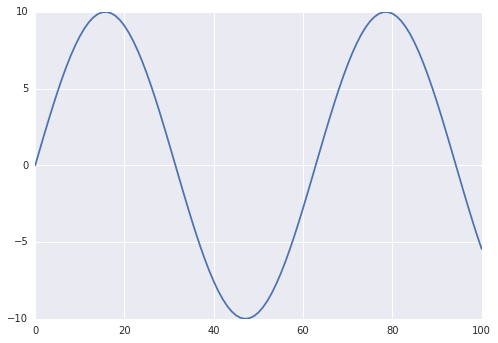

In [10]:
line_data = generate_data(10)
fig, ax = plt.subplots()
ax.plot(line_data.reshape(-1))
ax.grid(True)
ax.axis([0,100,-100/multiplier,100/multiplier])
plt.show()

In [11]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)

inputs_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchX_placeholder)
labels_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchY_placeholder)

In [12]:
cell = tf.contrib.rnn.core_rnn_cell.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

In [13]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]

losses = [tf.nn.l2_loss(labels - logits, name=None) for logits, labels in zip(logits_series,labels_series)]

total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_list = []

x_data = generate_data(total_series_length)
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])


for batch_idx in range(iterations):
    
    start_idx = batch_idx
    end_idx = start_idx + truncated_backprop_length

    batchX = x_data[:,start_idx:end_idx]
    batchY = x_data[:,start_idx+steps_to_predict:end_idx+steps_to_predict]

    _total_loss, _train_step, _current_state = sess.run(
        [total_loss, train_step, current_state],
        feed_dict={
            batchX_placeholder:batchX,
            batchY_placeholder:batchY,
            init_state:_current_state
        })

    loss_list.append(_total_loss)
    
    if (batch_idx)%(iterations/20) == 0:
        print 'Step',batch_idx, 'Loss =', _total_loss
        
print 'Done Training'

Step 0 Loss = 37.3614
Step 500 Loss = 2.04796
Step 1000 Loss = 0.555143
Step 1500 Loss = 0.151024
Step 2000 Loss = 0.0673906
Step 2500 Loss = 0.0735563
Step 3000 Loss = 0.0760689
Step 3500 Loss = 0.0971122
Step 4000 Loss = 0.106859
Step 4500 Loss = 0.105405
Step 5000 Loss = 0.205075
Step 5500 Loss = 0.123194
Step 6000 Loss = 0.129922
Step 6500 Loss = 0.10287
Step 7000 Loss = 0.0618983
Step 7500 Loss = 0.0304586
Step 8000 Loss = 0.064205
Step 8500 Loss = 0.0235474
Step 9000 Loss = 0.0279212
Step 9500 Loss = 0.0395935
Done Training


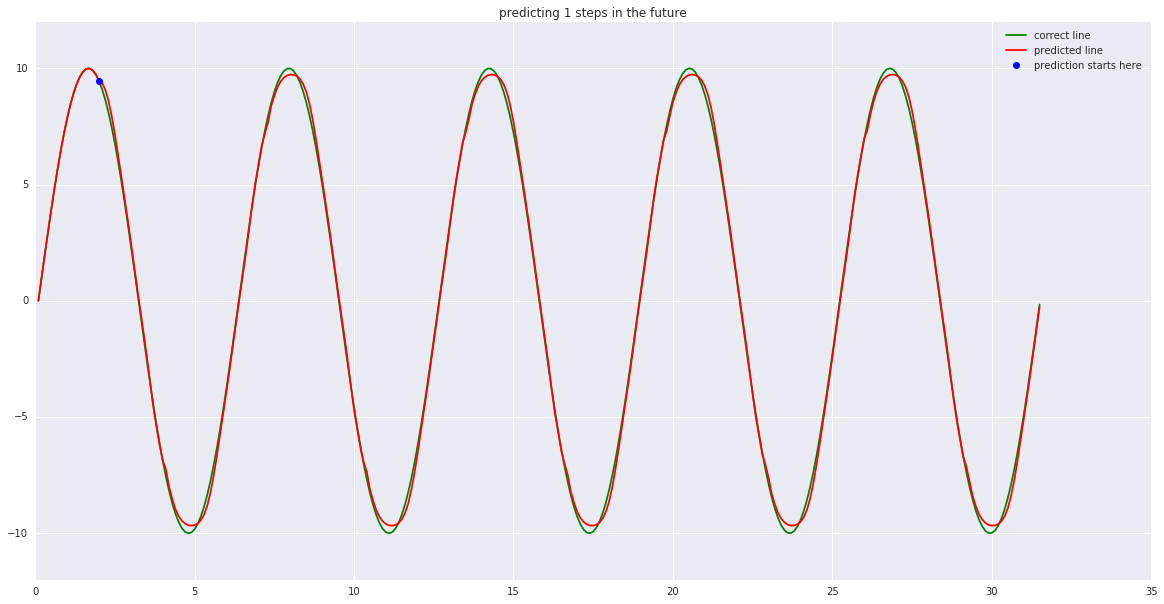

In [15]:
pred = Y = np.array([])
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])
X = np.array([])

n = 0
for i in range(315):
    Y = np.append(Y, multiplier*np.sin(n)).reshape(1,-1)
    
    if i < truncated_backprop_length:
        pred = np.append(pred, Y[:,-1])
        
    elif i >= truncated_backprop_length and (i-truncated_backprop_length) % steps_to_predict == 0:
        previous = np.array(Y[:,-(truncated_backprop_length+1):-1])
        pred = np.append(pred, sess.run([logits_series[-(steps_to_predict):truncated_backprop_length]], feed_dict={batchX_placeholder:previous, init_state:_current_state}))
        _current_state = sess.run(current_state, feed_dict={batchX_placeholder:previous, init_state:_current_state})
        
    
    n+= 0.1
    X = np.append(X, n)
    
Y = Y.reshape([-1])

plt.figure(figsize=(20,10))
plt.subplot()
plt.grid(True)
plt.title('predicting %s steps in the future' % steps_to_predict)
plt.plot(X,Y, 'g', label='correct line')
pred = pred[0:Y.size]
plt.plot(X,pred, 'r', label='predicted line')
plt.plot(X[truncated_backprop_length-1], pred[truncated_backprop_length-1], 'bo', label='prediction starts here')
plt.legend()
pylab.ylim([-12,12])
plt.show()